In [1]:
import tensorflow as tf
import pickle
from util import *
from load_data import load_input_file, build_combined_input
from NN_train import *
path_tosave = 'Models/V05_SvsS_All_Features'
mkdir_p(path_tosave)
features_to_ignore = []
#features_to_ignore = ["DPhill_SS"]
features_to_ignore = []

In [2]:
samples, feature_names, class_names, class_no = load_input_file('data/V05_SvsS.h5', features_to_ignore)

Found 23 features on the dataset 23 features were loaded: 

DEtall_SS
DPhill_SS
DRll01
HT_jets
HT_lep
Mll01
MtLepMet
jet_pseudoscore_DL1r0
jet_pseudoscore_DL1r1
jet_pseudoscore_DL1r2
DeltaR_max_lep_bjet77
DeltaR_min_lep_bjet77
DRjj_lead
jet_pt0_nofwd
met_met
total_charge
nJets_OR
nJets_OR_DL1r_77
sumPsbtag
sumPsbtag77
randomRunNumber
weight_cuu_0p00_cqu1_0p10_cqu8_0p20
weight_cuu_0p04
 


In [3]:
targets = []
sample0, *other = samples
targets.extend( np.ones( sample0.data().shape[0] ) * sample0.class_label() )
inputs = sample0.data()
targets = np.array(targets, dtype = int )
weights = inputs[:,-1]
inputs = inputs[:,0:-1]
targets = targets[np.where((weights<1) &(weights>0))]
inputs  = inputs[np.where((weights<1) &(weights>0))]
weights = weights[np.where((weights<1) &(weights>0))]
data_len = inputs.shape[0]

In [4]:
weights_cuu = inputs[:,-1]
weights_cqu = inputs[:,-2]
weights_cuu_int = (inputs[:,-1] * 10).astype(int)
weights_cqu_int = (inputs[:,-2] * 10).astype(int)
Number_org = inputs[:,-3]
inputs = inputs[:,0:-3]
feature_names = feature_names[0:-3]
feature_names

['DEtall_SS',
 'DPhill_SS',
 'DRll01',
 'HT_jets',
 'HT_lep',
 'Mll01',
 'MtLepMet',
 'jet_pseudoscore_DL1r0',
 'jet_pseudoscore_DL1r1',
 'jet_pseudoscore_DL1r2',
 'DeltaR_max_lep_bjet77',
 'DeltaR_min_lep_bjet77',
 'DRjj_lead',
 'jet_pt0_nofwd',
 'met_met',
 'total_charge',
 'nJets_OR',
 'nJets_OR_DL1r_77',
 'sumPsbtag',
 'sumPsbtag77']

In [5]:
reweighted_inputs = np.zeros([weights_cuu_int.sum()+weights_cqu_int.sum(),inputs.shape[1]])
targets = np.concatenate([np.zeros(weights_cuu_int.sum()), np.ones(weights_cqu_int.sum())])
Numbers = np.zeros([weights_cuu_int.sum()+weights_cqu_int.sum()])
counter = 0
for i in range(weights_cuu_int.shape[0]):
    for j in range(weights_cuu_int[i]):
        reweighted_inputs[counter,:] = inputs[i,:]
        Numbers[counter] = Number_org[i]
        counter +=1
for i in range(weights_cqu_int.shape[0]):
    for j in range(weights_cqu_int[i]):
        reweighted_inputs[counter,:] = inputs[i,:]
        Numbers[counter] = Number_org[i]
        counter +=1        

In [6]:
scaler = StandardScaler().fit(reweighted_inputs)
input_scaled = scaler.transform(reweighted_inputs)

In [7]:
norw_input_scaled = scaler.transform(inputs)

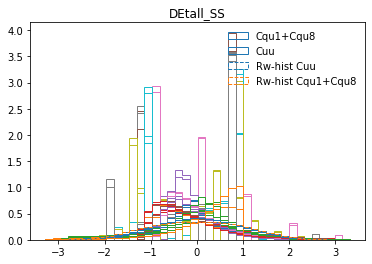

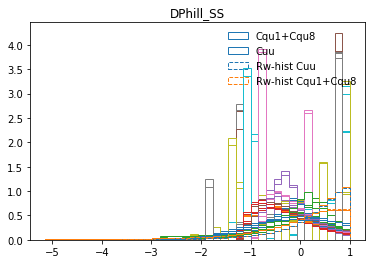

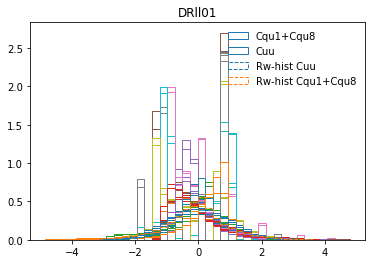

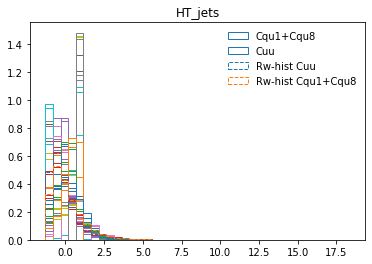

In [8]:
for i in range(input_scaled.shape[1]):
    max_val = input_scaled[:,i].max()
    min_val = input_scaled[:,i].min()
    plt.title(str(feature_names[i]))
    cqu = plt.hist(input_scaled[targets==1], bins=40, range=(min_val, max_val), histtype='step', label='Cqu1+Cqu8', density=True)
    cuu = plt.hist(input_scaled[targets==0], bins=40, range=(min_val, max_val), histtype='step', label='Cuu', density=True)
    plt.hist(norw_input_scaled[:,i], bins=40, histtype='step', linestyle=('dashed'), weights = weights_cuu, density=True, label='Rw-hist Cuu')
    plt.hist(norw_input_scaled[:,i], bins=40, histtype='step', linestyle=('dashed'), weights = weights_cqu, density=True, label='Rw-hist Cqu1+Cqu8')
    plt.legend(frameon=False)
    save_name = path_tosave + "/Input_Feature_" + str(i) + ".png"
    plt.savefig(save_name)
    plt.show()
    if i==3:
        break

In [9]:
def Fold_Odd_Even(input, targets, Number):
    input_odd = input[Number % 2 == 1]
    targets_odd = targets[Number % 2 == 1]
    input_even = input[Number % 2 == 0]
    targets_even = targets[Number % 2 == 0]
    return (input_odd, targets_odd), (input_even, targets_even)

In [10]:
odd, even = Fold_Odd_Even(input_scaled, targets, Numbers)

In [11]:
def Train_Odd_Even(odd, even, n_epochs = 400, batch_size = 2000):
    fit_history_list = []
    model_list = []
    input_shape = odd[0].shape[1]

    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lr_step_decay)

    X_odd, X_val_odd, y_odd, y_val_odd, = train_test_split(odd[0], odd[1], test_size=0.2)
    X_even, X_val_even, y_even, y_val_even, = train_test_split(even[0], even[1], test_size=0.2)

    model_odd = Create_Model_basic(input_shape)
    model_even = Create_Model_basic(input_shape)
    fit_history_odd = model_odd.fit(X_odd, y_odd, epochs = n_epochs, shuffle = True, batch_size = batch_size, validation_data=(X_val_odd, y_val_odd), verbose=1 ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 100, verbose = True, min_delta = 0.001),lr_schedule]) #
    fit_history_even = model_even.fit(X_even, y_even, epochs = n_epochs, shuffle = True, batch_size = batch_size, validation_data=(X_val_even, y_val_even), verbose=1 ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 100, verbose = True, min_delta = 0.001),lr_schedule]) #

    return fit_history_odd, model_odd, fit_history_even, model_even

In [12]:
input_shape = odd[0].shape[1]
n_epochs = 40
batch_size = 20000

In [13]:
history_odd, model_odd, history_even, model_even= Train_Odd_Even(odd, even, n_epochs = n_epochs, batch_size = batch_size)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 20)]              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               2688      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 136       
_________________________________________________________________
OutputLayer (Dense)          (None, 1)                 9     

/home/avdgraaf/.local/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


3137983/3137983 [==============================] - 3s 1us/sample - loss: 0.6224 - accuracy: 0.6586 - val_loss: 0.6119 - val_accuracy: 0.6661
Epoch 2/40
3137983/3137983 [==============================] - 3s 1us/sample - loss: 0.6111 - accuracy: 0.6662 - val_loss: 0.6096 - val_accuracy: 0.6674
Epoch 3/40
3137983/3137983 [==============================] - 2s 1us/sample - loss: 0.6092 - accuracy: 0.6673 - val_loss: 0.6091 - val_accuracy: 0.6674
Epoch 4/40
3137983/3137983 [==============================] - 3s 1us/sample - loss: 0.6086 - accuracy: 0.6677 - val_loss: 0.6078 - val_accuracy: 0.6680
Epoch 5/40
3137983/3137983 [==============================] - 3s 1us/sample - loss: 0.6084 - accuracy: 0.6677 - val_loss: 0.6076 - val_accuracy: 0.6688
Epoch 6/40
3137983/3137983 [==============================] - 3s 1us/sample - loss: 0.6077 - accuracy: 0.6682 - val_loss: 0.6071 - val_accuracy: 0.6681
Epoch 7/40
3137983/3137983 [==============================] - 3s 1us/sample - loss: 0.6074 - accura

3030268/3030268 [==============================] - 2s 1us/sample - loss: 0.6059 - accuracy: 0.6690 - val_loss: 0.6055 - val_accuracy: 0.6698
Epoch 15/40
3030268/3030268 [==============================] - 2s 1us/sample - loss: 0.6058 - accuracy: 0.6691 - val_loss: 0.6050 - val_accuracy: 0.6706
Epoch 16/40
3030268/3030268 [==============================] - 2s 1us/sample - loss: 0.6059 - accuracy: 0.6690 - val_loss: 0.6056 - val_accuracy: 0.6709
Epoch 17/40
3030268/3030268 [==============================] - 2s 1us/sample - loss: 0.6058 - accuracy: 0.6690 - val_loss: 0.6058 - val_accuracy: 0.6700
Epoch 18/40
3030268/3030268 [==============================] - 2s 1us/sample - loss: 0.6055 - accuracy: 0.6694 - val_loss: 0.6053 - val_accuracy: 0.6700
Epoch 19/40
3030268/3030268 [==============================] - 2s 1us/sample - loss: 0.6054 - accuracy: 0.6693 - val_loss: 0.6049 - val_accuracy: 0.6705
Epoch 20/40
3030268/3030268 [==============================] - 2s 1us/sample - loss: 0.6053 - 

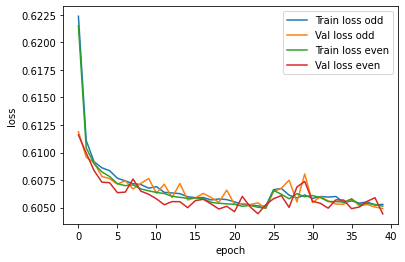

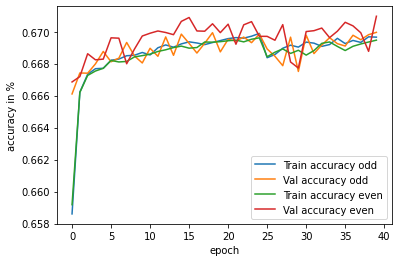

Saving architecture to: /mnt/c/Users/aaron/Desktop/PhD/Same_Sign_Top/NN_for_sstt/NN/Models/V05_SvsS_All_Features/architecture_odd.json
Saving weights to     : /mnt/c/Users/aaron/Desktop/PhD/Same_Sign_Top/NN_for_sstt/NN/Models/V05_SvsS_All_Features/weights_odd.h5
Saving architecture to: /mnt/c/Users/aaron/Desktop/PhD/Same_Sign_Top/NN_for_sstt/NN/Models/V05_SvsS_All_Features/architecture_even.json
Saving weights to     : /mnt/c/Users/aaron/Desktop/PhD/Same_Sign_Top/NN_for_sstt/NN/Models/V05_SvsS_All_Features/weights_even.h5


In [14]:
history_list = [history_odd, history_even]
Plot_Metrics_KFold(history_list, path_tosave)
Save_Model(model_odd, path_tosave, "_odd")
Save_Model(model_even, path_tosave, "_even")

In [15]:
model_odd = Load_Model(path_tosave, name="_odd")
model_even = Load_Model(path_tosave, name="_even")
pickle.dump(scaler, open(path_tosave + '/scaler.pkl','wb'))

Loading model architecture and weights (/mnt/c/Users/aaron/Desktop/PhD/Same_Sign_Top/NN_for_sstt/NN/Models/V05_SvsS_All_Features/architecture_odd.json, /mnt/c/Users/aaron/Desktop/PhD/Same_Sign_Top/NN_for_sstt/NN/Models/V05_SvsS_All_Features/weights_odd.h5)
Loading model architecture and weights (/mnt/c/Users/aaron/Desktop/PhD/Same_Sign_Top/NN_for_sstt/NN/Models/V05_SvsS_All_Features/architecture_even.json, /mnt/c/Users/aaron/Desktop/PhD/Same_Sign_Top/NN_for_sstt/NN/Models/V05_SvsS_All_Features/weights_even.h5)


In [16]:
def plot_roc_curve_SvS(model,data,path_tosave,odd=True):
    pred = model.predict(data[0])
    truth = data[1]
    fpr, tpr, thr = roc_curve(truth, pred)
    roc_auc = auc(fpr, tpr)

    fig = plt.figure()
    plt.plot(fpr, tpr, color='darkorange',
             label='ROC curve (area = {:.4f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    if odd==True:
        plt.savefig(path_tosave+"/ROC_odd_model.png")
    else:
        plt.savefig(path_tosave+"/ROC_even_model.png")
    plt.show()

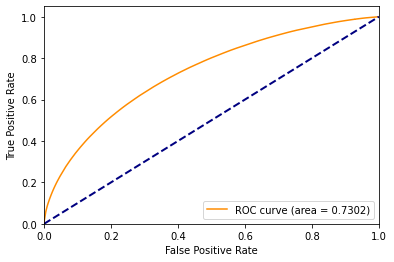

/home/avdgraaf/.local/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


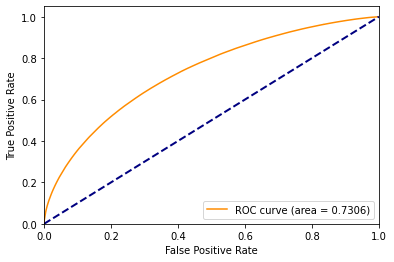

In [17]:
plot_roc_curve_SvS(model_even, odd, path_tosave, odd=False)
plot_roc_curve_SvS(model_odd, even, path_tosave, odd=True)

In [18]:
Predicted_even = model_odd.predict(even[0])
Predicted_odd = model_even.predict(odd[0])

In [19]:
Predicted_Combined = np.squeeze(np.concatenate([Predicted_even, Predicted_odd]))
targets_Combined = np.concatenate([even[1], odd[1]])

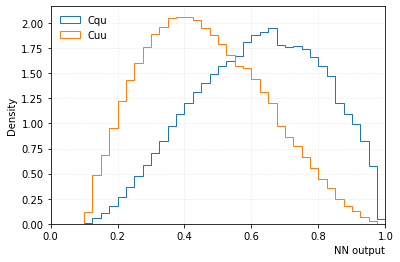

In [20]:
fig = plt.figure()
plt.grid(color='k', which='both', linestyle='--', lw=0.5, alpha=0.1, zorder = 0)
plt.xlabel("NN output", horizontalalignment='right', x=1)
plt.xlim([0,1])
plt.ylabel("Density")
histargs = {"bins":40, "range":(0,1.), "density":True, "histtype":'step'}
plt.hist(Predicted_Combined[targets_Combined==1],label = "Cqu", **histargs)
plt.hist(Predicted_Combined[targets_Combined==0],label = "Cuu", **histargs)
plt.legend(loc='upper left', frameon=False,)
saveit = "{}/{}".format(path_tosave, "DNN_Output.png")
plt.savefig(saveit)

# Testing with not really reweighted Data

In [21]:
samples, feature_names, class_names, class_no = load_input_file('data/V05_SvsS.h5', features_to_ignore)
targets = []

sample0, *other = samples
targets.extend( np.ones( sample0.data().shape[0] ) * sample0.class_label() )
inputs = sample0.data()
targets = np.array(targets, dtype = int )
weights = inputs[:,-1]
inputs = inputs[:,0:-1]
targets = targets[np.where((weights<1) &(weights>0))]
inputs  = inputs[np.where((weights<1) &(weights>0))]
weights = weights[np.where((weights<1) &(weights>0))]
data_len = inputs.shape[0]

weights_cuu = inputs[:,-1]
weights_cqu = inputs[:,-2]
weights_cuu_int = (inputs[:,-1] * 10).astype(int)
weights_cqu_int = (inputs[:,-2] * 10).astype(int)
Number_org = inputs[:,-3]
inputs = inputs[:,0:-3]
feature_names = feature_names[0:-3]
feature_names

Found 23 features on the dataset 23 features were loaded: 

DEtall_SS
DPhill_SS
DRll01
HT_jets
HT_lep
Mll01
MtLepMet
jet_pseudoscore_DL1r0
jet_pseudoscore_DL1r1
jet_pseudoscore_DL1r2
DeltaR_max_lep_bjet77
DeltaR_min_lep_bjet77
DRjj_lead
jet_pt0_nofwd
met_met
total_charge
nJets_OR
nJets_OR_DL1r_77
sumPsbtag
sumPsbtag77
randomRunNumber
weight_cuu_0p00_cqu1_0p10_cqu8_0p20
weight_cuu_0p04
 


['DEtall_SS',
 'DPhill_SS',
 'DRll01',
 'HT_jets',
 'HT_lep',
 'Mll01',
 'MtLepMet',
 'jet_pseudoscore_DL1r0',
 'jet_pseudoscore_DL1r1',
 'jet_pseudoscore_DL1r2',
 'DeltaR_max_lep_bjet77',
 'DeltaR_min_lep_bjet77',
 'DRjj_lead',
 'jet_pt0_nofwd',
 'met_met',
 'total_charge',
 'nJets_OR',
 'nJets_OR_DL1r_77',
 'sumPsbtag',
 'sumPsbtag77']

In [22]:
inputs_test = scaler.transform(inputs)

In [23]:
Predictions_even = model_odd.predict(inputs_test[Number_org % 2 == 0])
Predictions_odd = model_even.predict(inputs_test[Number_org % 2 == 1])
targets_even = targets[Number_org % 2 == 0]
targets_odd = targets[Number_org % 2 == 1]
weights_cuu_even = weights_cuu[Number_org % 2 == 0]
weights_cuu_odd = weights_cuu[Number_org % 2 == 1]
weights_cqu_even = weights_cqu[Number_org % 2 == 0]
weights_cqu_odd = weights_cqu[Number_org % 2 == 1]

Predictions = np.concatenate([Predictions_even,Predictions_odd])
targets = np.concatenate([targets_even, targets_odd])
weights_cuu = np.concatenate([weights_cuu_even, weights_cuu_odd])
weights_cqu = np.concatenate([weights_cqu_even, weights_cqu_odd])

In [27]:
Predictions.min()

0.061196238

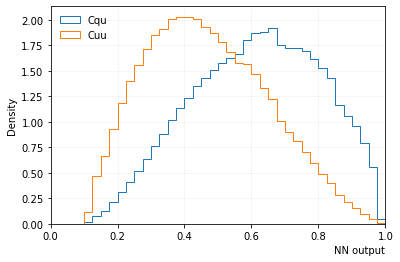

In [24]:
fig = plt.figure()
plt.grid(color='k', which='both', linestyle='--', lw=0.5, alpha=0.1, zorder = 0)
plt.xlabel("NN output", horizontalalignment='right', x=1)
plt.xlim([0,1])
plt.ylabel("Density")
histargs = {"bins":40, "range":(0,1.), "density":True, "histtype":'step'}
plt.hist(Predictions, label = "Cqu", **histargs, weights=weights_cqu)
plt.hist(Predictions, label = "Cuu", **histargs, weights=weights_cuu)
plt.legend(frameon=False, loc='upper left')
plt.savefig("DNN_Output.png")
plt.show()

# Test on Background

# Feature Importance

In [25]:
Sig = Predicted_Combined[targets_Combined==1]
Bkg = Predicted_Combined[targets_Combined==0]
Sig_Eff, Bkg_Eff, Signal_Cut = Find_Eff_Cut(Sig=Sig, Bkg=Bkg, Signal_Eff=0.75)

Cut_Value: 0.483
Sig_Eff: 0.750
Bkg_Eff: 0.428
Bkg Rejection: 2.336


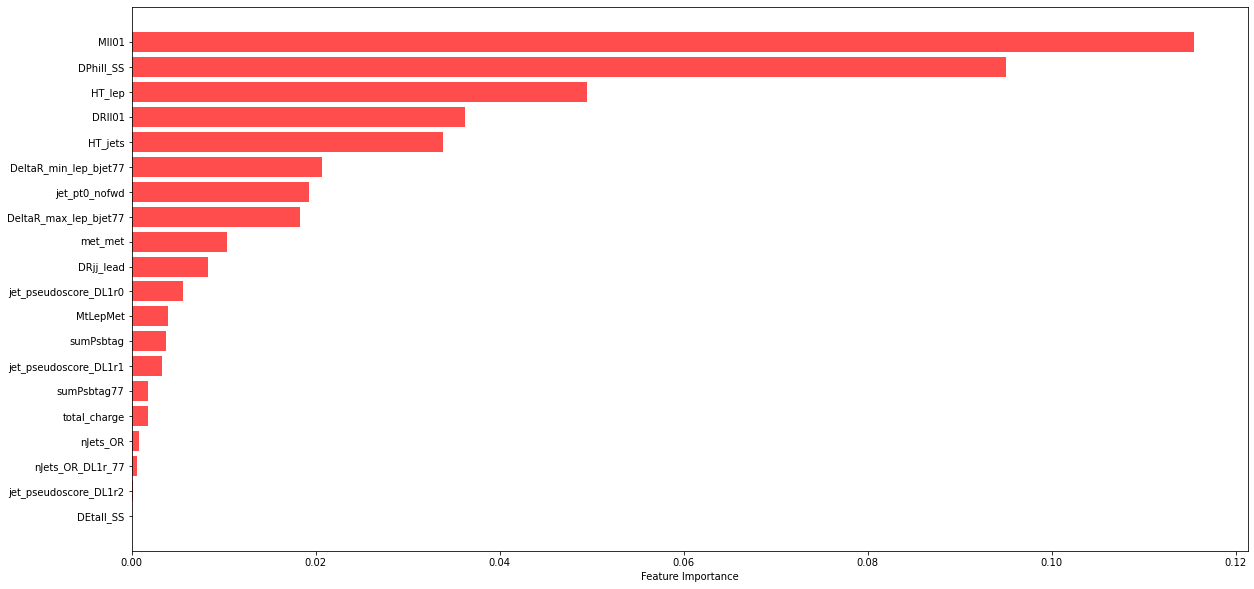

In [26]:
f, g = get_feature_importance(odd, model_even, Signal_Cut, 2)
idx = np.argsort(f)
fig, ax = plt.subplots(figsize=(20, 10))
ax.barh(range(odd[0].shape[1]), np.sort(f), color="r", alpha=0.7)
ax.set_yticks(range(odd[0].shape[1]), np.array(feature_names)[idx])
ax.set_xlabel('Feature Importance')
plt.savefig(path_tosave + "/Feature_Importance.png")